<a href="https://colab.research.google.com/github/hyunku/2022-BigdataCampusContest/blob/main/hyunku_MCLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyproj
!pip install haversine
!pip install dbfread
!pip install gurobipy
!pip install shapely

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.3 MB 14.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.5 MB 14.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import pyproj
# 지도 시각화
import folium
from folium.plugins import MiniMap
from folium.plugins import MarkerCluster
import warnings
warnings.filterwarnings('ignore')
from haversine import haversine, Unit
#dbf
from dbfread import DBF
import seaborn as sns
from scipy.spatial import distance_matrix
from gurobipy import *
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, Point
from numpy import random
import time
from shapely import *
import requests
import json

In [ ]:
도서관 = pd.read_csv("/content/drive/MyDrive/서울빅캠공모전/data file/전처리한 데이터/도서관.csv")
물가 = pd.read_csv("/content/drive/MyDrive/서울빅캠공모전/data file/전처리한 데이터/물가.csv")
보건시설 = pd.read_csv("/content/drive/MyDrive/서울빅캠공모전/data file/전처리한 데이터/보건시설_구포함.csv")
전월세 = pd.read_csv("/content/drive/MyDrive/서울빅캠공모전/data file/전처리한 데이터/전월세.csv")
착한업소 = pd.read_csv("/content/drive/MyDrive/서울빅캠공모전/data file/전처리한 데이터/착한가격업소.csv")
버스 = pd.read_csv("/content/drive/MyDrive/서울빅캠공모전/data file/버스정류장_위경도_주소.csv")
보육원 = pd.read_excel("/content/drive/MyDrive/서울빅캠공모전/data file/서울시 보육원.xlsx")

# 입지선정 후보지 - 보육원

In [ ]:
# 보육원
보육원 = 보육원.dropna()
보육원 = 보육원.loc[:,['위도','경도']]
보육원.head()

,위도,경도
0,37.601670,126.950861
1,37.601670,126.950861
2,37.046445,127.145740
3,37.485192,127.002220
4,37.553414,126.969173


# 전처리 - 구, 위도, 경도

In [ ]:
# 버스
버스['구'] = ''

for i in range(len(버스)):
  버스['구'][i] = 버스['주소'][i].split(',')[-4].strip()

버스 = 버스.iloc[:,[2,3,5]]
버스

,위도,경도,구
0,37.569764,126.987786,성북구
1,37.579179,126.996520,종로구
2,37.582709,126.998290,종로구
3,37.568582,126.987507,성북구
4,37.586230,127.001694,종로구
...,...,...,...
11175,37.550442,127.139326,강동구
11176,37.550620,127.140052,강동구
11177,37.533686,127.123477,강동구
11178,37.536199,127.125410,강동구


위치추천 후보지 데이터 : 보육원 <br>
위치추천 후보지 인풋 데이터 : 도서관, 보건시설, 착한업소, 버스 <br>
최종분석 : 물가, 전월세 <br>

In [ ]:
# 착한업소
aa = 착한업소.iloc[:,-3:]

for i in range(len(aa)):
  if aa['주소'][i][6:8] == "중구":
    aa['주소'][i] = "중구"
  else:
    aa['주소'][i] = aa['주소'][i][6:10].strip()

착한업소 = aa.copy()
착한업소.head()

,주소,위도,경도
0,강남구,37.493178,127.033851
1,강남구,37.491378,127.072705
2,강남구,37.491378,127.072705
3,강남구,37.491378,127.072705
4,강남구,37.493166,127.047328


# 메모

전월세는 좌표로 지정할수 없고 동별로 구역의 집값을 보는 것임 -> 전월세 데이터 제외한 데이터들로 MCLP 수행후 입지추천 후보지 구역들을 시각화해서 지도에 나타낸후, 전월세 데이터로 동별 가격 비교하며 최후 추천 해야할듯!

해야할것 정리 : <br>
2. 전통시장, 대형마트 전처리 마무리해서 합친거 전처리한 데이터에 넣기
3. 보육원 na값 채우기

앞으로 방향성

일단 가중치 적용하는거 해볼것임. -> 어떤 속성에 가장 큰 가중치를 둘지 결정을 어떻게 할까

# 구별로 MCLP 진행 - 예시) 강남구

In [ ]:
착한업소_지역 = 착한업소[착한업소['주소'] == '영등포구'] # 강남구 데이터만 선택
착한업소_지역 = 착한업소_지역.iloc[:,-2:] # 위경도만 보기
착한업소_지역 = 착한업소_지역.replace(0, np.NaN) # 0값 na값으로 변경
착한업소_지역 = 착한업소_지역.dropna() # na값 제거
착한업소_지역

,위도,경도
446,37.509684,126.916936
447,37.508709,126.898822
448,37.531326,126.905055
449,37.492343,126.909145
450,37.535944,126.897834
451,37.524517,126.884700
452,37.504088,126.919870
453,37.524792,126.885108
454,37.505384,126.902256
455,37.533076,126.905455


In [ ]:
# 경도가 x좌표, 위도가 y좌표

도서관_지역 = 도서관[도서관['SIG_NM'] == '영등포구']
도서관_지역 = 도서관_지역.iloc[:,-2:]
도서관_지역

,위도,경도
135,37.531881,126.919274
136,37.504325,126.896095
137,37.516860,126.890911
138,37.525815,126.907199
139,37.533338,126.892954
140,37.522188,126.919934
961,37.486264,126.903195
962,37.499369,126.915405
963,37.506987,126.900879
964,37.506193,126.899654


In [ ]:
버스_지역 = 버스[버스['구'] == '영등포구']
버스_지역 = 버스_지역.iloc[:,[0,1]]
버스_지역

,위도,경도
7725,37.511696,126.893656
7726,37.511169,126.892252
7727,37.514793,126.902184
7728,37.514452,126.900834
7729,37.515986,126.905632
...,...,...
8230,37.534969,126.899832
8231,37.527075,126.905675
8254,37.510052,126.924378
8365,37.514708,126.927334


In [ ]:
보건시설 = 보건시설.iloc[:,[2,3,5]]
보건시설 = 보건시설.dropna()

for i in range(len(보건시설)):
  보건시설['구'][i] = 보건시설['구'][i].strip()

보건시설_지역 = 보건시설[보건시설['구'] == '영등포구']
보건시설_지역 = 보건시설_지역.iloc[:,[0,1]]
보건시설_지역

,위도,경도
2,37.533246,126.903755
3,37.511376,126.912498
6,37.522324,126.891193
81,37.533327,126.903596
148,37.518732,126.903362
...,...,...
1338,37.518934,126.908779
1340,37.506790,126.909491
1357,37.521308,126.905323
1388,37.498867,126.904617


In [ ]:
df = pd.concat([착한업소_지역, 도서관_지역, 버스_지역, 보건시설_지역], axis=0)
df = df.reset_index(drop=True)
df

,위도,경도
0,37.509684,126.916936
1,37.508709,126.898822
2,37.531326,126.905055
3,37.492343,126.909145
4,37.535944,126.897834
...,...,...
613,37.518934,126.908779
614,37.506790,126.909491
615,37.521308,126.905323
616,37.498867,126.904617


In [ ]:
df = df.reindex(columns=['경도','위도'])
points = df.values
points

array([[126.916936  ,  37.5096839 ],
       [126.8988221 ,  37.5087088 ],
       [126.9050554 ,  37.5313264 ],
       ...,
       [126.90532258,  37.52130753],
       [126.90461732,  37.49886677],
       [126.90422639,  37.52854576]])

In [ ]:
# 2000개 이하여야 구로비 라이센스 없이 돌아감,,,
len(points)

618

# 1. 기존 점들 중 하나를 기준점으로 가정하고 MCLP 지정 -> 완전 새로운 입지는 아님 (기존에 있는 지점)

In [ ]:
def mclp(points,K,radius):
    """
    Solve maximum covering location problem
    Input:
        points: 수요지점 좌표 (기타 인근에 있으면 좋은 시설 좌표)
        K: 설치할 시설의 수
        radius: 구간의 반지름
    Return:
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        f: the optimal value of the objective function
    """
    print('  Number of points %g' % points.shape[0])
    print('  K %g' % K)
    print('  Radius %g' % radius)

    start = time.time()
    sites = np.array([list(i) for i in zip(보육원['경도'], 보육원['위도'])])
    J = sites.shape[0]                                         # 입지후보지 수
    I = points.shape[0]                                        # 수요지점 수
    D = distance_matrix(points,sites)                          # 입지후보지와 수요지점 간 거리 계산
    mask1 = D<=radius
    D[mask1]=1                                                 # 수요지점별로 입지후보지의 반경 내 속하면 1, 아니면 0
    D[~mask1]=0
    # Build model
    m = Model()
    # Add variables
    x = {}
    y = {}
    for i in range(I):                                        
        y[i] = m.addVar(vtype=GRB.BINARY, name="y%d" % i)     # 모델에 수요지점 변수 추가 (변수 유형은 BINARY. 위치별 인수, 변수 이름 y+숫자)
    for j in range(J):
        x[j] = m.addVar(vtype=GRB.BINARY, name="x%d" % j)     # 입지후보지 변수 추가

    m.update()
    # Add constraints
    m.addConstr(quicksum(x[j] for j in range(J)) == K)        # 입지후보지 제약 조건 (K개)

    for i in range(I):                                        # 수요지점 제약 조건
        m.addConstr(quicksum(x[j] for j in np.where(D[i]==1)[0]) >= y[i])

    m.setObjective(quicksum(y[i] for i in range(I)),GRB.MAXIMIZE)     # 목적함수 (제약 조건 포함. 모든 수요지점 더하기)
    m.setParam('OutputFlag', 0)
    m.optimize()
    end = time.time()
    print('----- Output -----')
    print('  Running time : %s seconds' % float(end-start))
    print('  Optimal coverage points: %g' % m.objVal)
    
    solution = []
    if m.status == GRB.Status.OPTIMAL:
        for v in m.getVars():
            # print v.varName,v.x
            if v.x==1 and v.varName[0]=="x":
                solution.append(int(v.varName[1:]))
    opt_sites = sites[solution]
    return opt_sites,m.objVal

In [ ]:
opts_sites, mobjVal = mclp(points,10, 0.003)
opts_sites

  Number of points 618
  K 10
  Radius 0.003
----- Output -----
  Running time : 0.026587247848510742 seconds
  Optimal coverage points: 26


array([[126.95086078,  37.6016702 ],
       [126.95086078,  37.6016702 ],
       [127.14573988,  37.04644485],
       [127.00222023,  37.48519249],
       [126.96917318,  37.5534137 ],
       [127.02212178,  37.5605461 ],
       [126.90925491,  37.5016399 ],
       [126.91315024,  37.49735765],
       [126.90483591,  37.49401392],
       [126.91315024,  37.49735765]])

In [ ]:
최적입지 = pd.DataFrame(opts_sites, columns=['경도','위도'])
최적입지

,경도,위도
0,126.950861,37.601670
1,126.950861,37.601670
2,127.145740,37.046445
3,127.002220,37.485192
4,126.969173,37.553414
5,127.022122,37.560546
6,126.909255,37.501640
7,126.913150,37.497358
8,126.904836,37.494014
9,126.913150,37.497358


In [ ]:
def plot_input(points):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        radius: the radius of circle
    '''
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(8,8))
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)

In [ ]:
def plot_result(points,opt_sites,radius):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        radius: the radius of circle
    '''
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(8,8))
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    plt.scatter(opt_sites[:,0],opt_sites[:,1],c='C1',marker='+')
    for site in opt_sites:
        circle = plt.Circle(site, radius, color='C1',fill=False,lw=2)
        ax.add_artist(circle)
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)

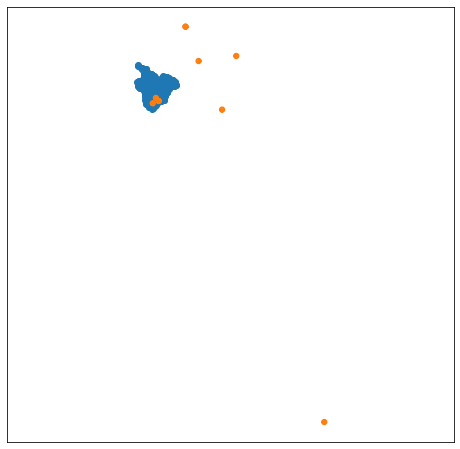

In [ ]:
plot_result(points, opts_sites, 0.003)

# 2. 신규 입지 추천

In [ ]:
# 추천된 구간 내 임의의 지점 추천

# 보유하고 있는 좌표(points)의 모양에 맞는 도형 생성
# 해당 도형 안에 포함되는 random한 좌표 생성 (임의의 시설 위치 좌표)

def generate_candidate_sites(points, M=100):
    '''
    Generate M candidate sites with the convex hull of a point set
    Input:                                                                            인풋
        points: a Numpy array with shape of (N,2)                                 -> 입지추천에 사용될 좌표들
        M: the number of candidate sites to generate                              -> 추천 입지 개수
    Return:                                                                          아웃풋
        sites: a Numpy array with shape of (M,2)                                  -> 추천된 입지들의 좌표 리스트
    '''
    hull = ConvexHull(points)                                   # points 좌표들로 외곽선 생성 (모든 점들을 포함하는 최소 크기의 볼록)
    polygon_points = points[hull.vertices]                      # 외곽선을 구성하는 직선 간 점(좌표) 반환
    poly = Polygon(polygon_points)                              # 외곽선 모양의 도형 생성
    min_x, min_y, max_x, max_y = poly.bounds                    # 도형의 x축과 y축 좌표 최소,최대
    sites = []
    while len(sites) < M:
        random_point = Point([random.uniform(min_x, max_x),     # x축 범위 내 random한 값
                              random.uniform(min_y, max_y)])    # y축 범위 내 random한 값
        if (random_point.within(poly)):                         # random한 좌표가 도형 안에 있다면 sites에 추가
            sites.append(random_point)
    return np.array([(p.x,p.y) for p in sites])

def mclp(points,K,radius,M):
    """
    Solve maximum covering location problem                                          인풋 파라미터
    Input:
        points: input points, Numpy array in shape of [N,2]                       -> 입지추천에 사용될 좌표들
        K: the number of sites to select                                          -> 입지추천할 구역 개수 설정 (원 형태)
        radius: the radius of circle                                              -> 입지추천할 구역의 반지름 (구역 크기)
        M: the number of candidate sites, which will randomly generated inside    -> 내부적으로 랜덤하게 추출해줄 입지추천 후보지 수
        the ConvexHull wrapped by the polygon
    Return:                                                                          리턴 값들
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]       -> 입지 추천된 최적 장소 (좌표값 리턴)
        f: the optimal value of the objective function
    """
    print('----- Configurations -----')
    print('  Number of points %g' % points.shape[0])
    print('  K %g' % K)
    print('  Radius %g' % radius)
    print('  M %g' % M)
    import time
    start = time.time()
    sites = generate_candidate_sites(points,M) # 입지 추천된 좌표들
    print(f"sites : {sites}, shape: {sites.shape}, shape[0]: {sites.shape[0]}") # 디버깅용으로 찍어봤습니다
    J = sites.shape[0]  # 입지후보지 개수
    I = points.shape[0] # 입지추천에 사용될 총 좌표 개수
    D = distance_matrix(points,sites) # 추천된 지점과 입지후보지들간의 거리 행렬 -> 입지후보지들과 입지추천에 사용될 좌표들간의 거리계산
    mask1 = D<=radius # 거리행렬에서 입지추천할 구역의 반지름 값보다 작은 거리를 가진 부분만 추출 
    D[mask1]=1 # 거리 행렬에 mask속성으로 입지추천에 사용된 좌표값이 입지후보 구역 내에 속하면 1 입력
    D[~mask1]=0 # 거리 행렬에 mask속성으로 입지추천에 사용된 좌표값이 입지후보 구역 내에 속하지 않으면 0 입력
    # Build model
    m = Model()
    # Add variables
    x = {} # 입지후보지를 키값으로 저장할 딕셔너리
    y = {} # 입지추천에 사용된 좌표들를 키값으로 저장할 딕셔너리
    for i in range(I): # 입지추천에 사용된 좌표들을 순회
      y[i] = m.addVar(vtype=GRB.BINARY, name="y%d" % i) # 모델에 입지추천에 사용한 좌표들 변수 추가 (변수 유형은 BINARY. 위치별 인수, 변수 이름 y+숫자)
    for j in range(J): # 입지후보지 좌표들 순회
      x[j] = m.addVar(vtype=GRB.BINARY, name="x%d" % j) # 모델에 입지후보지 변수 추가

    m.update() # 모델 업데이트
    # Add constraints
    m.addConstr(quicksum(x[j] for j in range(J)) == K) # 입지후보지 제약 조건 (K개)

    for i in range(I): # 입지추천에 사용된 지역의 제약 조건
        m.addConstr(quicksum(x[j] for j in np.where(D[i]==1)[0]) >= y[i])

    m.setObjective(quicksum(y[i]for i in range(I)),GRB.MAXIMIZE) # 목적함수 (제약 조건 포함. 모든 입지추천에 사용된 지점들 더하기)
    m.setParam('OutputFlag', 0)
    m.optimize()
    end = time.time()
    print('----- Output -----')
    print('  Running time : %s seconds' % float(end-start))
    print('  Optimal coverage points: %g' % m.objVal)
    
    solution = []
    if m.status == GRB.Status.OPTIMAL:
        for v in m.getVars():
            # print v.varName,v.x
            if v.x==1 and v.varName[0]=="x":
               solution.append(int(v.varName[1:]))
    opt_sites = sites[solution]
    return opt_sites,m.objVal

def plot_input(points):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        radius: the radius of circle
    '''
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(8,8))
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)

def plot_result(points,opt_sites,radius):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        radius: the radius of circle
    '''
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(8,8))
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    plt.scatter(opt_sites[:,0],opt_sites[:,1],c='C1',marker='+')
    for site in opt_sites:
        circle = plt.Circle(site, radius, color='C1',fill=False,lw=2)
        ax.add_artist(circle)
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)

In [ ]:
# mclp(입지선정에 사용될 데이터, 입지추천 확정 지역 수, 입지추천 구역 반지름, 입지추천 후보지 지역 수)

opts_sites, mobjVal = mclp(points, 10, 0.0035, 20)
opts_sites

----- Configurations -----
  Number of points 618
  K 10
  Radius 0.0035
  M 20
sites : [[126.9108233   37.49730709]
 [126.91966777  37.50889007]
 [126.89281184  37.50336054]
 [126.90491258  37.52591753]
 [126.91551231  37.53369753]
 [126.92956315  37.52606427]
 [126.89391266  37.53241657]
 [126.92160746  37.52707013]
 [126.91049979  37.50503   ]
 [126.90496796  37.50827115]
 [126.89617822  37.52982464]
 [126.90407292  37.53612477]
 [126.91219007  37.5104928 ]
 [126.90400126  37.52934862]
 [126.90693465  37.49562493]
 [126.8885225   37.51847222]
 [126.92029631  37.50865009]
 [126.91145582  37.50473526]
 [126.90180519  37.50378498]
 [126.92396674  37.53108403]], shape: (20, 2), shape[0]: 20
----- Output -----
  Running time : 0.021682024002075195 seconds
  Optimal coverage points: 173


array([[126.9108233 ,  37.49730709],
       [126.91966777,  37.50889007],
       [126.92956315,  37.52606427],
       [126.89391266,  37.53241657],
       [126.90496796,  37.50827115],
       [126.91219007,  37.5104928 ],
       [126.90400126,  37.52934862],
       [126.8885225 ,  37.51847222],
       [126.91145582,  37.50473526],
       [126.90180519,  37.50378498]])

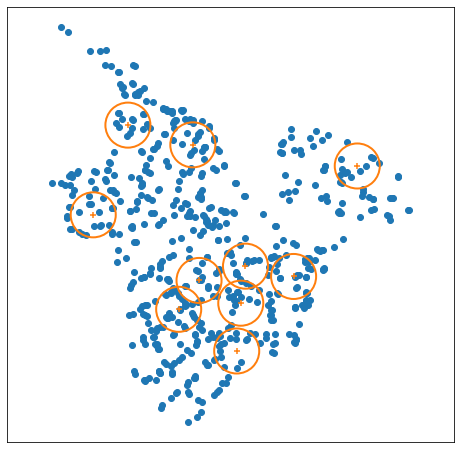

In [ ]:
plot_result(points, opts_sites, 0.0035)

In [ ]:
point_df = pd.DataFrame(opts_sites)
point_df.columns = ['lon', 'lat']
point_df

,lon,lat
0,126.910823,37.497307
1,126.919668,37.508890
2,126.929563,37.526064
3,126.893913,37.532417
4,126.904968,37.508271
5,126.912190,37.510493
6,126.904001,37.529349
7,126.888523,37.518472
8,126.911456,37.504735
9,126.901805,37.503785


In [ ]:
lons_arr = points[:,0]
lon_mean = sum(lons_arr) / len(lons_arr)
lats_arr = points[:,1]
lat_mean = sum(lats_arr) / len(lats_arr)

In [ ]:
lats = point_df['lat']
lons = point_df['lon']

In [ ]:
# 서울 행정구역 json raw파일(githubcontent)
r = requests.get('https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo_simple.json')
c = r.content
seoul_geo = json.loads(c)

In [ ]:
map = folium.Map([lat_mean, lon_mean], zoom_start = 13)

folium.GeoJson(
    seoul_geo,
    name='지역구'
).add_to(map)

for lat, lon in zip(lats, lons):
    folium.Circle(location = [lat, lon], radius = 300, color='black', fill_color = 'black', weight=1).add_to(map)
map

In [ ]:
lon_kind = 착한업소_지역['경도']
lat_kind = 착한업소_지역['위도']
lon_lib = 도서관_지역['경도']
lat_lib = 도서관_지역['위도']
lon_bogun = 보건시설_지역['경도']
lat_bogun = 보건시설_지역['위도']
lon_bus = 버스_지역['경도']
lat_bus = 버스_지역['위도']

In [ ]:
for lat, lon in zip(lat_kind, lon_kind):
    folium.Circle(location = [lat, lon], radius = 50, color='blue', fill_color = 'blue', weight=1).add_to(map)

for lat, lon in zip(lat_lib, lon_lib):
    folium.Circle(location = [lat, lon], radius = 50, color='red', fill_color = 'red', weight=1).add_to(map)

for lat, lon in zip(lat_bogun, lon_bogun):
    folium.Circle(location = [lat, lon], radius = 50, color='green', fill_color = 'green', weight=1).add_to(map)

for lat, lon in zip(lat_bus, lon_bus):
    folium.Circle(location = [lat, lon], radius = 50, color='purple', fill_color = 'purple', weight=1).add_to(map)
map

현구 : 보육원들을 인풋으로 해서 모든 데이터를 사용해서 시각화 (추천원 반지름은 걸어서 15~20분정도 거리) + 가능하면 격자무늬 땅값데이터 보는거??

파란색 : 착한업소 : 3점<br>
빨간색 : 도서관 : 1점<br><br>

-> 6점짜리 존재